#### Importing neccessary libraries

1. **Numpy** for *linear algebra*
2. **Pandas** for reading csv files and DataFrame handling
3. **Tensorflow** for *machine learning*
4. **Keras** for defining the *LSTM model architecture* and regularization
5. Functions such as **train_test_split** for dividing the dataset into training and test set and **GridSearchCV** to tune hyperparameters across a grid of values.
6. **MinMaxScaler** to scale the variable values to a range of $[0,1]$.  
7. **matplotlib** for plotting results
8. **logging** for errors.

In [1]:
pip install scikeras

In [152]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from itertools import product
import matplotlib.pyplot as plt
import logging
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 6 iterations:
1. -> 1 lstm layers gridsearch  
2. -> 2 lstm layer gridsearch  
3. -> 1 lstm layer med l1 eller l2 gridsearch  
4. -> 1 lstm layer for kun makro gridsearch  
5. -> 1 lstm layer for kun technical gridsearch  
6. -> 1 lstm layer med inflation og unemployment + tekniske (Momentum, RSI, MACD, MA) gridsearch


## Configuration of logging:

In [153]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')

## Setting Device to GPU

Since the model is run in Google Colab with an external GPU for increased computational ability the device which is used needs to be defined:

In [154]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    logging.warning('GPU device not found. Use CPU instead')
else:
    logging.info(f'Found GPU at: {device_name}')

# Data Loading

In [219]:
logging.info('Loading dataset...')

file_path = '/content/final_dataset.csv'
df = pd.read_csv(file_path)
dataset = df.values[:, 0:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,0:1]

In [220]:
np.random.seed(42)
tf.random.set_seed(42)

# Output Variable Transformation and Data Scaling

In [221]:
# Define a function to categorize the percent change
# Values for (25,75) and (40,60) percentiles are listed below. Both will be tested.
# 34.1 quantile: -0.0021999999999999
# 65 quantile:  0.002

def categorize_diff(diff):
    if diff < -0.0021999999999999:
        return 0  # Price falls
    elif diff > 0.0021999999999999:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the function to y_diff to get the categories
logging.info('Categorizing percent change...')
y_categories = np.array([categorize_diff(pc) for pc in diff])

In [222]:
y_categories = to_categorical(y_categories)

# Normalizing dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:, 1:])

# Conversion to Tensor

In [223]:
def create_dataset(dataset, time_steps = 1):
    dataX = []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), :]
        dataX.append(a)
    return np.array(dataX)

# 1st Iteration

* time steps = 10,
* epochs = 100,
* 1 hidden layer,
* 0.3 dropout rate,
* 32 batch size,

In [160]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [166]:
def create_model(units1=128, dropout_rate1 = 0.1, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [167]:
model = KerasClassifier(model = create_model, epochs = 75, verbose = 0, shuffle = False, random_state = 42)

In [171]:
param_grid = {
    'model__units1': [32],
    'model__dropout_rate1': [0.1],
    'batch_size': [128]
}

In [172]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs = -1)

In [174]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

# Fit the grid search
grid_result = grid.fit(X_train, y_train, callbacks = [early_stopping], validation_split = 0.2)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [175]:
best_params = grid_result.best_params_
logging.info(f"Best Parameters: {best_params}")
print(best_params)

{'batch_size': 128, 'model__dropout_rate1': 0.1, 'model__units1': 32}


{'batch_size': 128, 'model__dropout_rate1': 0.1, 'model__units1': 32}

In [176]:
best_model = create_model(batch_size = 128,
                          dropout_rate1 = 0.2,
                          units1 = 32,
                          )

In [177]:
early_stopping_manual = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(X_train, y_train,
                         epochs = 75,
                         batch_size = 128,
                         validation_data = (X_test, y_test),
                         shuffle = False,
                         callbacks = [early_stopping_manual],
                         verbose = 0
                         )

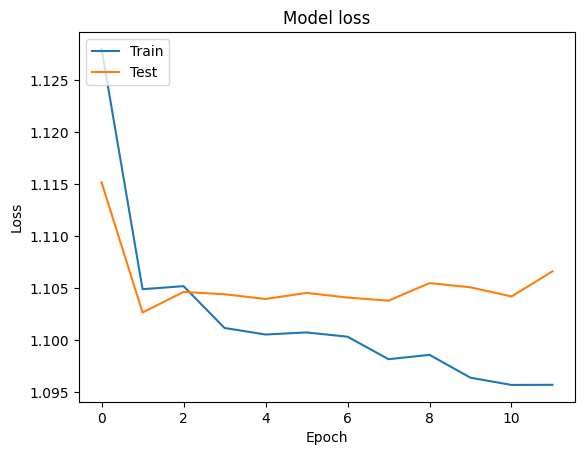

In [178]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


<Figure size 1000x700 with 0 Axes>

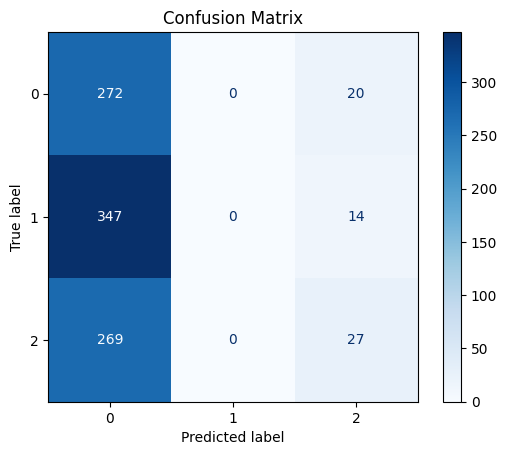

In [179]:
# Assuming `grid_result` is the result from GridSearchCV and contains the best model

# Predict on the test set
y_pred = best_model.predict(X_test)

# Convert the one-hot encoded actual labels back to integer format
actual_categories = np.argmax(y_test, axis=1)

# Get the predicted categories
predicted_categories = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [254]:
file_path = '/content/usd_eur_raw.csv'
df_raw_exchange = pd.read_csv(file_path)

df_raw_exchange = df_raw_exchange['usd_eur_exchange'].pct_change()

df_raw_exchange = df_raw_exchange.iloc[3:-1]

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Assuming the functions to create and compile your model are defined as `create_model`

def compute_hit_rate(signals, percent_changes):
    correct_signals = 0
    total_signals = len(signals)

    for signal, percent_change in zip(signals, percent_changes):
        if (signal == 0 and percent_change < 0) or (signal == 2 and percent_change > 0):
            correct_signals += 1
        elif signal == 1:
            total_signals -= 1

    return correct_signals / total_signals if total_signals > 0 else 0

def backtest(actions, percent_changes):
    cash = 100  # Initial cash
    position = 0  # Current position: 0 for flat, -1 for short, 1 for long
    portfolio_value = []  # Portfolio value over time

    for action, percent_change in zip(actions, percent_changes):
        if action == 0:  # Sell
            position = -100  # Set position to short
            cash += position * percent_change  # Sell shares
        elif action == 1:  # Flat
            position = 0  # Set position to flat
            cash += 0  # No action
        elif action == 2:  # Buy
            position = 100  # Set position to long
            cash += position * percent_change  # Buy shares

        portfolio_value.append(cash)  # Calculate portfolio value

    return portfolio_value

def run_single_iteration(X_train, y_train, X_test, y_test, best_params):
    # Create the model with the best parameters
    best_model = create_model(batch_size = 128,
                              dropout_rate1 = 0.1,
                              units1 = 32
    )

    early_stopping_manual = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = best_model.fit(X_train, y_train,
                             epochs=75,
                             validation_data=(X_test, y_test),
                             batch_size = 128,
                             shuffle=False,
                             callbacks=[early_stopping_manual],
                             verbose=0)

    # Predict on the test set
    predictions = best_model.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)

    # Convert y_test from one-hot encoding to label format
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, predicted_categories)

    # Generate signals based on predicted categories
    signals = predicted_categories
    percent_changes = np.array(df_raw_exchange.iloc[-len(y_test):])

    # Run the backtest
    portfolio_value = backtest(signals, percent_changes)
    hit_rate = compute_hit_rate(signals, percent_changes)
    num_trades = np.sum((signals == 0) | (signals == 2))


    return portfolio_value, accuracy, hit_rate, num_trades

# Number of iterations for averaging
iterations = 50

# Lists to store the results of each iteration
final_portfolio_values = []
accuracies = []
hit_rates = []
trade_counts = []

for i in range(iterations):
    print(f"Running iteration {i+1}/{iterations}")
    portfolio_value, accuracy, hit_rate, num_trades = run_single_iteration(X_train, y_train, X_test, y_test, best_params)
    final_portfolio_values.append(portfolio_value[-1])
    accuracies.append(accuracy)
    hit_rates.append(hit_rate)
    trade_counts.append(num_trades)
    print(f"Iteration {i+1} - Final Portfolio Value: {portfolio_value[-1]}, Accuracy: {accuracy}, Hit Rate: {hit_rate}, Trades: {num_trades}")

# Calculate the average and standard deviation of the final portfolio values
average_final_value = np.mean(final_portfolio_values)
std_final_value = np.std(final_portfolio_values)

# Calculate the average accuracy and hit rate
average_accuracy = np.mean(accuracies)
average_hit_rate = np.mean(hit_rates)
average_num_trades = np.mean(trade_counts)

# Print results
print("Average Final Portfolio Value:")
print(average_final_value)
print('Standard Deviation of Final Values:')
print(std_final_value)
print('Average Accuracy:')
print(average_accuracy)
print('Average Hit Rate:')
print(average_hit_rate)
print('Average No. of Trades:')
print(average_num_trades)

Running iteration 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Iteration 1 - Final Portfolio Value: 99.0169484989736, Accuracy: 0.3076923076923077, Hit Rate: 0.5015806111696522, Trades: 949
Running iteration 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 2 - Final Portfolio Value: 113.28427503307672, Accuracy: 0.3266596417281349, Hit Rate: 0.514721919302072, Trades: 917
Running iteration 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Iteration 3 - Final Portfolio Value: 104.4487128720442, Accuracy: 0.31401475237091675, Hit Rate: 0.5142255005268704, Trades: 949
Running iteration 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 4 - Final Portfolio Value: 94.04975646742147, Accuracy: 0.3856691253951528, Hit Rate: 0.47335423197492166, Trades: 319
Running iteration 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Iteration 5 - Final Portfolio Value: 99.63238345549118, Accuracy: 0.3835616438356164, Hit Rate: 0.5555555555555556, Trades: 9
Running iteration 6/50
30/30 ━━━━━━━━━━━━━━━━━━━

Model results from Grid search:

{'batch_size': 128, 'model__dropout_rate1': 0.2, 'model__units1': 64}

# 2nd Iteration

2 lstm layer gridsearch

In [224]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [225]:
def create_model_2(units1=128, units2 = 64, dropout_rate1 = 0.3, dropout_rate2 = 0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = True),
        Dropout(dropout_rate1),
        LSTM(units2, return_sequences = False),
        Dropout(dropout_rate2),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [202]:
model_2 = KerasClassifier(model=create_model_2, epochs = 75, verbose=0, shuffle = False, random_state = 42)

In [203]:
param_grid_model2 = {
    'model__units1': [64],
    'model__units2': [32],
    'model__dropout_rate1': [0.4],
    'model__dropout_rate2': [0.3],
    'batch_size': [32]
}

In [204]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_2 = GridSearchCV(estimator=model_2, param_grid=param_grid_model2, cv=5, n_jobs = -1)

In [206]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

# Fit the grid search
grid_result_model_2 = grid_model_2.fit(X_train, y_train, callbacks = [early_stopping], validation_split = 0.2)

In [207]:
best_params_model_2 = grid_result_model_2.best_params_
logging.info(f"Best Parameters: {best_params_model_2}")
print(best_params_model_2)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__dropout_rate2': 0.3, 'model__units1': 64, 'model__units2': 32}


In [226]:
best_model_2 = create_model_2(units1=best_params_model_2['model__units1'],
                            units2 = best_params_model_2['model__units2'],
                          dropout_rate1 = best_params_model_2['model__dropout_rate1'],
                            dropout_rate2 = best_params_model_2['model__dropout_rate2'],
                          batch_size = best_params_model_2['batch_size']
                          )

In [227]:
early_stopping_manual = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_model_2 = best_model_2.fit(X_train, y_train,
                         epochs=75,
                        batch_size = 32,
                         validation_data=(X_test, y_test),
                        callbacks = [early_stopping_manual],
                         verbose=0)

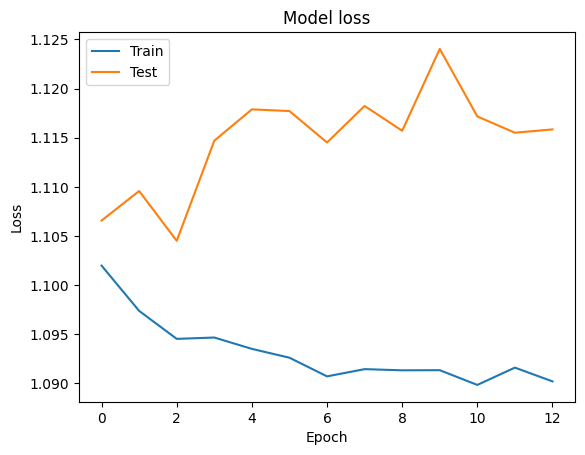

In [228]:
# Plot training & validation loss values
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


<Figure size 1000x700 with 0 Axes>

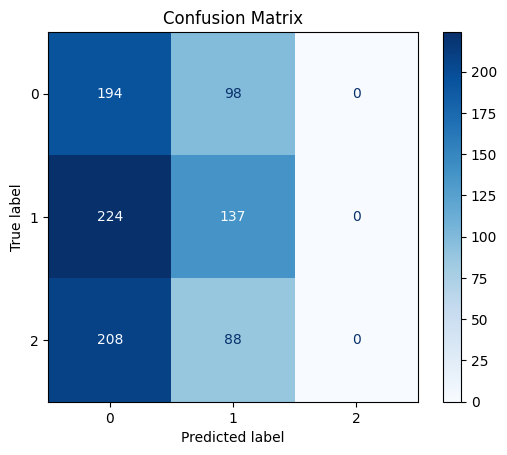

In [229]:
# Assuming `grid_result` is the result from GridSearchCV and contains the best model

# Predict on the test set
y_pred = best_model_2.predict(X_test)

# Convert the one-hot encoded actual labels back to integer format
actual_categories = np.argmax(y_test, axis=1)

# Get the predicted categories
predicted_categories = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Assuming the functions to create and compile your model are defined as `create_model`

def compute_hit_rate(signals, percent_changes):
    correct_signals = 0
    total_signals = len(signals)

    for signal, percent_change in zip(signals, percent_changes):
        if (signal == 0 and percent_change < 0) or (signal == 2 and percent_change > 0):
            correct_signals += 1
        elif signal == 1:
            total_signals -= 1

    return correct_signals / total_signals if total_signals > 0 else 0

def backtest(actions, percent_changes):
    cash = 100  # Initial cash
    position = 0  # Current position: 0 for flat, -1 for short, 1 for long
    portfolio_value = []  # Portfolio value over time

    for action, percent_change in zip(actions, percent_changes):
        if action == 0:  # Sell
            position = -100  # Set position to short
            cash += position * percent_change  # Sell shares
        elif action == 1:  # Flat
            position = 0  # Set position to flat
            cash += 0  # No action
        elif action == 2:  # Buy
            position = 100  # Set position to long
            cash += position * percent_change  # Buy shares

        portfolio_value.append(cash)  # Calculate portfolio value

    return portfolio_value

def run_single_iteration(X_train, y_train, X_test, y_test, best_params):
    # Create the model with the best parameters
    best_model_2 = create_model_2(batch_size=best_params_model_2['batch_size'],
                                  dropout_rate1=best_params_model_2['model__dropout_rate1'],
                                  units1=best_params_model_2['model__units1'],
                                  units2=best_params_model_2['model__units2'],
                                  dropout_rate2=best_params_model_2['model__dropout_rate2']
                                  )

    early_stopping_manual = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = best_model_2.fit(X_train, y_train,
                               epochs=75,
                               batch_size = 32,
                               validation_data=(X_test, y_test),
                               shuffle=False,
                               callbacks=[early_stopping_manual],
                               verbose=0)

    # Predict on the test set
    predictions = best_model_2.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)

    # Convert y_test from one-hot encoding to label format
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, predicted_categories)

    # Generate signals based on predicted categories
    signals = predicted_categories
    percent_changes = np.array(df_raw_exchange.iloc[-len(y_test):])

    # Run the backtest
    portfolio_value = backtest(signals, percent_changes)
    hit_rate = compute_hit_rate(signals, percent_changes)

    # Count the number of trades
    num_trades = np.sum((signals == 0) | (signals == 2))

    return portfolio_value, accuracy, hit_rate, num_trades

# Number of iterations for averaging
iterations = 50

# Lists to store the results of each iteration
final_portfolio_values = []
accuracies = []
hit_rates = []
trade_counts = []

for i in range(iterations):
    print(f"Running iteration {i+1}/{iterations}")
    portfolio_value, accuracy, hit_rate, num_trades = run_single_iteration(X_train, y_train, X_test, y_test, best_params)
    final_portfolio_values.append(portfolio_value[-1])
    accuracies.append(accuracy)
    hit_rates.append(hit_rate)
    trade_counts.append(num_trades)
    print(f"Iteration {i+1} - Final Portfolio Value: {portfolio_value[-1]}, Accuracy: {accuracy}, Hit Rate: {hit_rate}, Trades: {num_trades}")

# Calculate the average and standard deviation of the final portfolio values
average_final_value = np.mean(final_portfolio_values)
std_final_value = np.std(final_portfolio_values)

# Calculate the average accuracy, hit rate, and number of trades
average_accuracy = np.mean(accuracies)
average_hit_rate = np.mean(hit_rates)
average_trades = np.mean(trade_counts)

# Print results
print("Average Final Portfolio Value:")
print(average_final_value)
print("Standard Deviation of Final Values:")
print(std_final_value)
print("Average Accuracy:")
print(average_accuracy)
print("Average Hit Rate:")
print(average_hit_rate)
print("Average Number of Trades:")
print(average_trades)


Running iteration 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__dropout_rate2': 0.3, 'model__units1': 64, 'model__units2': 32}

In [ ]:
best_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 15, 128)             │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 635,531 (2.42 MB)

 Trainable params: 211,843 (827.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 423,688 (1.62 MB)

In [ ]:
model_2_save_path = 'second_iteration_lstm.keras'
best_model_2.save(model_2_save_path)
logging.info(f"Model saved to {model_2_save_path}")


# 3rd Iteration

1 lstm layer med l1 eller l2 gridsearch  


In [ ]:
from tensorflow.keras.regularizers import l1_l2

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def create_model_3(units1=128, dropout_rate1 = 0.3, batch_size = 32, l1 = 0.01, l2 = 0.01):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax', kernel_regularizer = l1_l2(l1=l1, l2=l2))
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_3 = KerasClassifier(model=create_model_3, epochs = 100, verbose=0, random_state = 42)

In [ ]:
param_grid_model3 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128],
    'model__l1': [0.01, 0.001],
    'model__l2': [0.01, 0.001]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_3 = GridSearchCV(estimator=model_3, param_grid=param_grid_model3, cv=5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_3 = grid_model_3.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
best_params_model_3 = grid_result_model_3.best_params_
logging.info(f"Best Parameters: {best_params_model_3}")
print(best_params_model_3)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__l1': 0.01, 'model__l2': 0.01, 'model__units1': 128}


In [ ]:
best_model_3 = create_model_3(units1 = best_params_model_3['model__units1'],
                          dropout_rate1 = best_params_model_3['model__dropout_rate1'],
                          batch_size = best_params_model_3['batch_size'],
                          l1 = best_params_model_3['model__l1'],
                          l2 = best_params_model_3['model__l2']
                          )

In [ ]:
history_model_3 = best_model_3.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_test, y_test),
                         verbose=0)

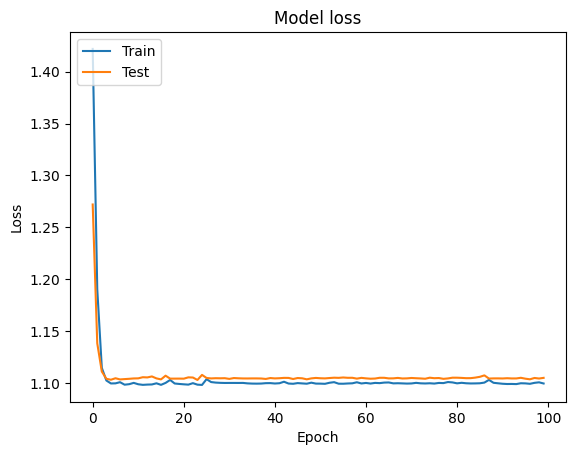

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 1000x700 with 0 Axes>

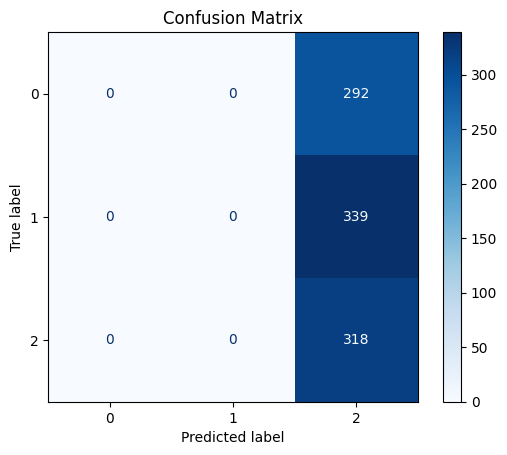

In [ ]:
y_pred = best_model_3.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model_3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

In [ ]:
model_3_save_path = 'third_iteration_lstm.keras'
best_model_3.save(model_3_save_path)
logging.info(f"Model saved to {model_3_save_path}")


# 4th Iteration

SLSTM with only technical variables


In [ ]:
logging.info('Loading dataset...')

file_path = '/content/technical_indicators_stationary.csv'
df = pd.read_csv(file_path)
df = df.drop(columns = ['date'])
dataset = df.values[:, 0:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,1:2]

In [ ]:
print(diff)

[[-0.0003]
 [-0.0105]
 [-0.0125]
 ...
 [ 0.0079]
 [-0.0041]
 [-0.0011]]


In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
def create_model_4(units1 = 128, dropout_rate1 = 0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation = 'softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
param_grid_model_4 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.1, 0.2, 0.3],
    'batch_size': [32, 64, 128]
}

In [ ]:
model_4 = KerasClassifier(model=create_model_4, epochs = 75, verbose=0, random_state = 42)

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_4 = GridSearchCV(estimator=model_4, param_grid=param_grid_model_4, cv=5, scoring = 'accuracy', n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_4 = grid_model_4.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
best_params_model_4 = grid_result_model_4.best_params_
logging.info(f"Best Parameters: {best_params_model_4}")
print(best_params_model_4)

{'batch_size': 64, 'model__dropout_rate1': 0.3, 'model__units1': 32}


In [ ]:
best_model_4 = create_model_4(units1 = best_params_model_4['model__units1'],
                          dropout_rate1 = best_params_model_4['model__dropout_rate1'],
                          batch_size = best_params_model_4['batch_size']
                          )

In [ ]:
history_model_4 = best_model_4.fit(X_train, y_train,
                         epochs=30,
                         validation_data=(X_test, y_test),
                         verbose=0)

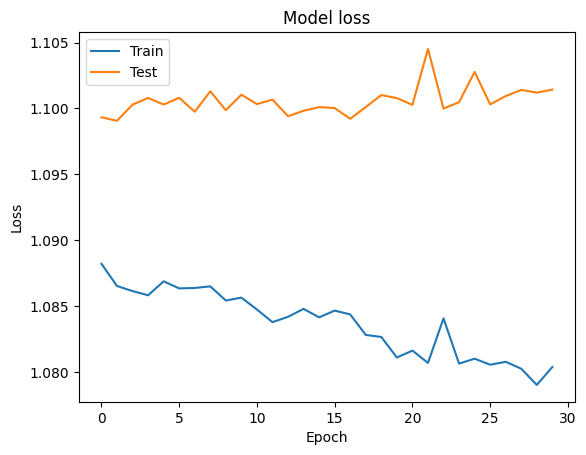

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_4.history['loss'])
plt.plot(history_model_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 1000x700 with 0 Axes>

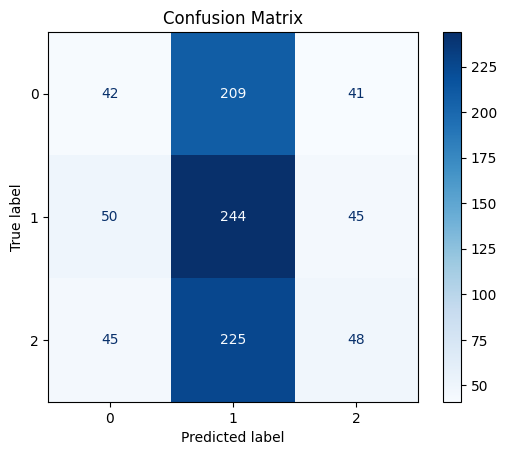

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model_4.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,195 (67.17 KB)

 Trainable params: 5,731 (22.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,464 (44.79 KB)

In [ ]:
model_4_save_path = 'fourth_iteration_lstm.keras'
best_model_4.save(model_4_save_path)
logging.info(f"Model saved to {model_4_save_path}")

# 5th Model (Not run yet)

In [ ]:
logging.info('Loading dataset...')

file_path = '/content/usd_eur_raw.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['date'])
dataset = df.values.astype('float64')

In [ ]:
# Extract the target variable (e.g., the second column which is the raw usd/eur exchange rate)
target = dataset[:, 1]

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the entire dataset including the input and target
scaled_dataset = scaler.fit_transform(dataset)


In [ ]:
time_steps = 15

def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :-1])  # Use all columns except the last one for input
        y.append(data[i + time_steps, -1])       # Use the last column for target
    return np.array(X), np.array(y)

# Create the lagged dataset
X, y = create_dataset(scaled_dataset, time_steps)

# Reshape X for LSTM input
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to 3D array for LSTM: [samples, time steps, features]

# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense, Input
from tensorflow.keras.losses import Huber

def create_model_5(units1=128, dropout_rate1=0.3, batch_size=32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mae'])
    return model

In [ ]:
from scikeras.wrappers import KerasRegressor

model_5 = KerasRegressor(build_fn=create_model_5, epochs = 75, verbose=0, random_state = 42)

In [ ]:
param_grid_model_5 = {
    'model__units1': [32, 64, 128, 256],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_5 = GridSearchCV(estimator=model_5, param_grid=param_grid_model_5, cv=5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_5 = grid_model_5.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
best_params_model_5 = grid_result_model_5.best_params_
logging.info(f"Best Parameters: {best_params_model_5}")
print(best_params_model_5)

{'batch_size': 128, 'model__dropout_rate1': 0.2, 'model__units1': 32}


In [ ]:
best_model_5 = create_model_5(batch_size = best_params_model_5['batch_size'],
                          dropout_rate1 = best_params_model_5['model__dropout_rate1'],
                          units1 = best_params_model_5['model__units1'],
                          )

In [ ]:
history_model_5 = best_model_5.fit(X_train, y_train,
                         epochs = 200,
                         validation_data = (X_test, y_test),
                         verbose=1,
                          shuffle = False
                         )

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0270 - mae: 0.1238 - val_loss: 0.0619 - val_mae: 0.2275
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - mae: 0.1234 - val_loss: 0.0561 - val_mae: 0.2169
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - mae: 0.1114 - val_loss: 0.0456 - val_mae: 0.1929
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - mae: 0.1020 - val_loss: 0.0339 - val_mae: 0.1612
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - mae: 0.0923 - val_loss: 0.0235 - val_mae: 0.1275
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - mae: 0.0837 - val_loss: 0.0160 - val_mae: 0.1004
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - mae: 0.0772 - val_loss: 0.0114 - val_mae: 0.0829
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - mae: 0.0703 - val_loss: 0.0086 - val_mae: 0.0720
Epoch 9/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

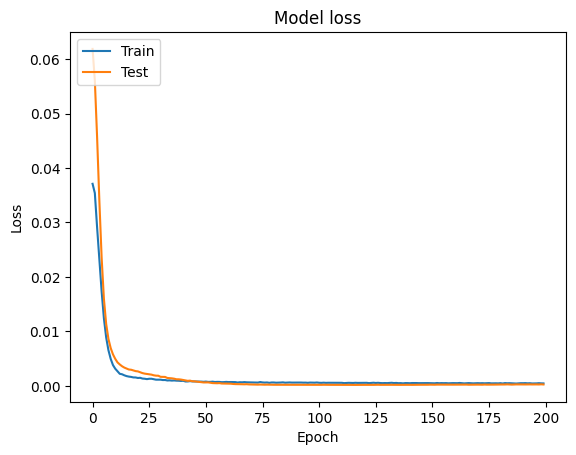

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_5.history['loss'])
plt.plot(history_model_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error (MSE): 0.00024104626232107396
Mean Absolute Error (MAE): 0.007965821631733124
R^2 Score: 0.9760116227971773
Out-of-Sample (OOS) R^2 Score: -1762.501763496988


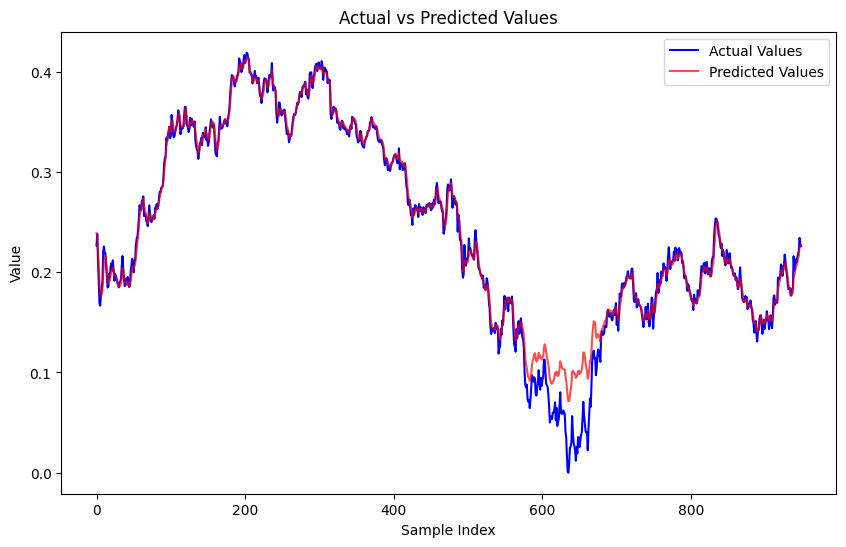

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = best_model_5.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# Calculate Out-of-Sample (OOS) R^2
def oos_r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

oos_r2 = oos_r2_score(y_test, y_pred)
print(f'Out-of-Sample (OOS) R^2 Score: {oos_r2}')

# Plot actual vs predicted values using line plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='b')
plt.plot(range(len(y_test)), y_pred, label='Predicted Values', color='r', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

ValueError: x and y must be the same size

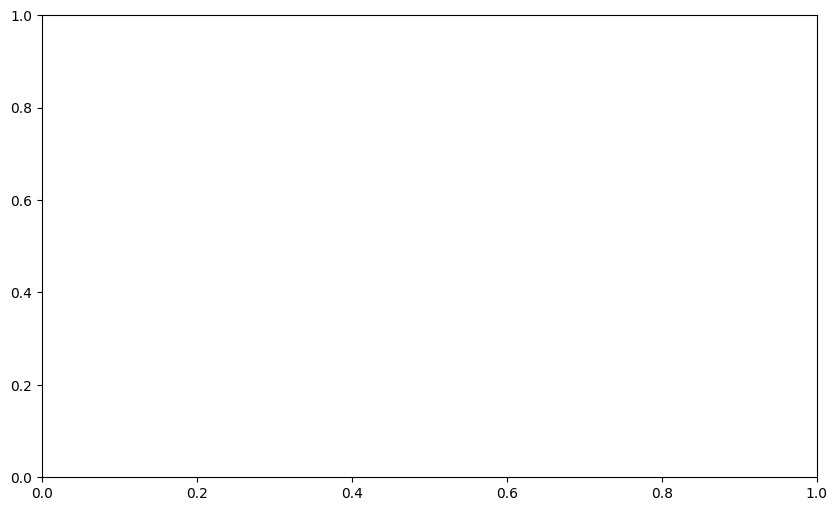

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=len(residuals), linestyles='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.title('Residuals Plot')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<Figure size 1000x700 with 0 Axes>

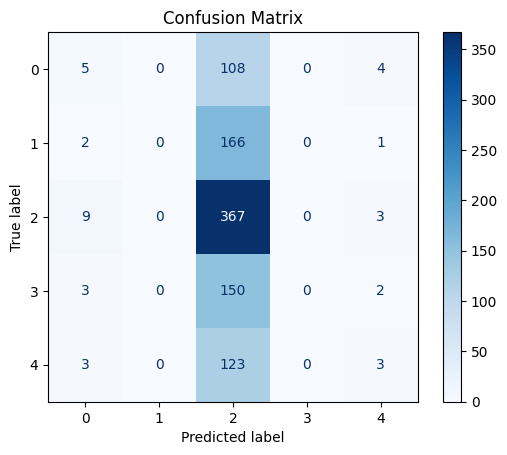

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = best_model_5.predict(X_test)

# Since best_model_5 is likely a Keras model wrapped in a Scikit-learn classifier,
# we need to convert predictions from probability distributions to class labels.
predicted_categories = np.argmax(y_pred, axis=1)

# Ensure that actual_categories has the correct length
actual_categories = y_test

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
best_model_5.summary()

In [ ]:
model_save_path = 'fifth_iteration_lstm.keras'
best_model_5.save(model_save_path)
logging.info(f"Model saved to {model_save_path}")


# Testing one hot encoding

In [ ]:
import numpy as np
import pandas as pd
import logging
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

logging.info('Loading dataset...')

file_path = '/content/select_technical_all_nonstationary.csv'
df = pd.read_csv(file_path)
df = df.drop(columns = ['date'])
dataset = df.values[:, 0:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,1:2]

def categorize_diff(diff):
    if diff < -0.0023999999999999:
        return 0  # Price falls
    elif diff > 0.0021999999999999:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the categorization
y_categories = np.array([categorize_diff(pc) for pc in diff])

# Verify the distribution of categories
unique, counts = np.unique(y_categories, return_counts=True)
print(dict(zip(unique, counts)))

# Normalize dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset[:, 1:])

# Prepare the dataset for LSTM
time_steps = 15

def create_dataset(data, labels, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(labels[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_dataset(dataset_scaled, y_categories, time_steps)

{2: 4758}


In [ ]:
# Split into train and test sets ensuring no data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Verify the shape of the dataset and the one-hot encoded labels
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train_one_hot: {y_train_one_hot.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test_one_hot: {y_test_one_hot.shape}')

# Check the label distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Training set label distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test set label distribution:", dict(zip(unique, counts)))

# Define the LSTM model for multi-class classification
def create_model(units1=64, dropout_rate1=0.2, learning_rate=0.001, batch_size=64):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences=False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')  # Softmax activation for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(units1=64, dropout_rate1=0.2, learning_rate=0.001, batch_size=64)
history = model.fit(X_train, y_train_one_hot, epochs=75, validation_data=(X_test, y_test_one_hot), verbose=1)

# Evaluate the model
results = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

# Generate predictions and confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()


Shape of X_train: (3794, 15, 21)
Shape of y_train_one_hot: (3794, 3)
Shape of X_test: (949, 15, 21)
Shape of y_test_one_hot: (949, 3)
Training set label distribution: {2: 3794}
Test set label distribution: {2: 949}
Epoch 1/75


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 3)

In [ ]:

# Calculate diff
diff = dataset[:, 18:19]

def categorize_diff(diff):
    if diff < -0.0023999999999999:
        return 0  # Price falls
    elif diff > 0.0021999999999999:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the categorization
y_categories = np.array([categorize_diff(pc) for pc in diff.flatten()])

# Verify the distribution of categories
unique, counts = np.unique(y_categories, return_counts=True)
print(dict(zip(unique, counts)))

# Normalize dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# Prepare the dataset for LSTM
time_steps = 15

def create_dataset(data, labels, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(labels[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_dataset(dataset_scaled, y_categories, time_steps)

# Split into train and test sets ensuring no data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Verify the shape of the dataset and the one-hot encoded labels
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train_one_hot: {y_train_one_hot.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test_one_hot: {y_test_one_hot.shape}')

# Check the label distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Training set label distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test set label distribution:", dict(zip(unique, counts)))

# Define the LSTM model for multi-class classification
def create_model(units1=64, dropout_rate1=0.2, learning_rate=0.001, batch_size = 64):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')  # Softmax activation for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(units1=64, dropout_rate1=0.2, learning_rate=0.001, batch_size = 64)
history = model.fit(X_train, y_train_one_hot, epochs=75, validation_data=(X_test, y_test_one_hot), verbose=1)

# Evaluate the model
results = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

# Generate predictions and confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 800x600 with 0 Axes>

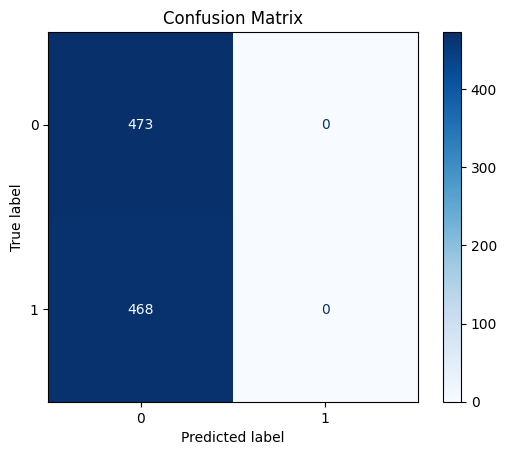

In [ ]:
# Predict the classes for the test set
y_pred_prob = model_5.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded test labels back to single dimension
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Display the confusion matrix
plt.figure(figsize=(8, 6))
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()